In [ ]:
# GENERATE FEATURES FOR MODEL

import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from torchvision import transforms
from PIL import Image
# from tensorflow.keras import layers
import cv2
from scipy import spatial
from skimage.metrics import structural_similarity

# Calculates the number of edges represented in a given pin array (row x col)
def calculateComplexity(contourImg, floodFilledImg, pinArraySize, tilePixelDensityComplexityThreshold=0.05):
  row_win_size = int(contourImg.shape[0]/pinArraySize[1])
  col_win_size = int(contourImg.shape[1]/pinArraySize[0])

  rowSteps = int(contourImg.shape[0]/row_win_size)
  colSteps = int(contourImg.shape[1]/col_win_size)

  # print("Row steps: {}, Col steps: {}, Row size: {}, Col size: {}, Img shape Y: {}, Img shape X: {}, Pin array: {}".format(
  #     rowSteps, colSteps, row_win_size, col_win_size, contourImg.shape[0], contourImg.shape[1], pinArraySize[0]))

  floodFillComplexityTileScores = []
  edgesComplexityTileScores = []

  for rowStep in range(rowSteps):
    for colStep in range(colSteps):

      # Count edge density per tile
      edgePixelCount=0
      for rowOffset in range(row_win_size):
        for colOffset in range(col_win_size):
          if(contourImg[rowStep*row_win_size + rowOffset][colStep*col_win_size + colOffset] > 0):
            edgePixelCount += 1

      edgesComplexityTileScores.append(float(edgePixelCount))

      # Count flood fill zones density per tile
      floodFillComplexityTileScores.append(
          float(
              countFloodFillZones(
                floodFilledImg,
                rowStep*row_win_size,
                (rowStep+1)*row_win_size,
                colStep*col_win_size,
                (colStep+1)*col_win_size
              )
          )
        )

  # return sum(complexityTileScores)/(rowSteps*colSteps)
  ffComplexityV1 = ffComplexityV2 = 0
  for i in floodFillComplexityTileScores:
    if(i>2):
      ffComplexityV1 += 1
      ffComplexityV2 += i

  winSizeInPixels = row_win_size*col_win_size
  edgeComplexityV1 = edgeComplexityV2 = 0
  nonEmptyTileCount = 0
  pinArr = []
  index = 0
  pinArrayRowIndex = 0
  pinArrayColIndex = 0

  for edgePixelCountForTile in edgesComplexityTileScores:
    # print("Pixed counts: {}, {}".format(edgePixelCountForTile, winSizeInPixels))
    edgePixelDensity = edgePixelCountForTile/winSizeInPixels
    if(edgePixelDensity > tilePixelDensityComplexityThreshold):
      edgeComplexityV1 += 1
      edgeComplexityV2 += i
      nonEmptyTileCount += 1
    elif edgePixelCountForTile > 0:
      nonEmptyTileCount += 1

    # Edge Pixel Density ranges from 0 to 1. Scale to pin intensity by multiplying that by 255.
    pinArr.append(int(edgePixelDensity * 255))

  if(nonEmptyTileCount == 0):
    print("Non-empty tile count was 0....Really?!!")
    nonEmptyTileCount = -1

  # print("---------  {}, {}".format(edgeComplexityV1, nonEmptyTileCount))

  ffPercentiles = np.percentile(floodFillComplexityTileScores, [50, 80, 90])
  edgePercentiles = np.percentile(edgesComplexityTileScores, [50, 80, 90])
  return [
          [1+ffComplexityV1/(rowSteps*colSteps), 1+ffComplexityV2/(rowSteps*colSteps), ffPercentiles[0], ffPercentiles[1], ffPercentiles[2],
          1+float(edgeComplexityV1)/(rowSteps*colSteps), 1+edgeComplexityV2/(rowSteps*colSteps), edgePercentiles[0], edgePercentiles[1], edgePercentiles[2], 1+(float(edgeComplexityV1)/nonEmptyTileCount)
          ],
          np.reshape(pinArr, (-1, colSteps))
  ]

def floodFillImage(img, startColor=100):
  '''
  Assumes a black/white image with contour detection already done.
  Flood fill changes are made directly to the passed in image, so make a copy if you don't want the original modified.
  '''
  mask1 = np.zeros((img.shape[0]+2, img.shape[1]+2), np.uint8)

  currentColor = startColor
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if(img[i][j] < startColor):
        # print("Processing ({}, {}) for image of size ({})".format(i, j, contourImgGray.shape))
        cv2.floodFill(img, mask1,(j,i),currentColor)
        currentColor += 30
        if(currentColor > 255):
          currentColor = 115

# https://stackoverflow.com/questions/53358598/filling-edges-using-flood-fill-not-working-properly
def countFloodFillZones(img, start_x, end_x, start_y, end_y):
  dict = {}
  for i in range(start_x, end_x):
    for j in range(start_y, end_y):
      if(img[i][j] == 255):
        continue

      if(img[i][j] in dict):
        dict[img[i][j]] += 1
      else:
        dict[img[i][j]] = 1
    return len(dict)

# def getContourImagePath(outputPathPrefix, imageName):

def generateCannyEdgeImageAndWriteToFile(img, outputPathPrefix, imageName, gbParams, thrParams, doWrite=True):
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  features = pd.DataFrame()
  for gaussianBlur in gbParams:
      img_blur = cv2.GaussianBlur(img_gray, (gaussianBlur,gaussianBlur), 0)
      for thhold in thrParams:
          thr1 = thhold[0]
          thr2 = thhold[1]
          edges = cv2.Canny(image=img_blur, threshold1=thr1, threshold2=thr2) # Canny Edge Detection
          # Display Canny Edge Detection Image
          # print(edges)

          # print('Original: ', img.shape)
          # print('Canny: ', edges.shape)
          # print('Collapsed:', edgeCount.shape)

          final = cv2.merge([edges, edges, edges])
          contourImg = final
          combined = cv2.hconcat([img, final])

          pinArrSizesArr = [(10, 10), (20, 12)]
          outputPath = "{}/{}/".format(outputPathPrefix, imageName)
          imgSuffix = "{}.jpgGB-{}_Th1-{}_Th2-{}.jpg".format(imageName, gaussianBlur, thr1, thr2)
          combinedImgSuffix = "Combined_{}".format(imgSuffix)
          floodFillImgSuffix = "Floodfill_{}".format(imgSuffix)
          pinArrayImg_Suffix = "PinArray_{}_{}"
          pinArrayImg_100_Suffix = "PinArray_100x100_{}".format(imgSuffix)
          pinArrayImg_2012_Suffix = "PinArray_20x12_{}".format(imgSuffix)
          pinArrayImg_2028_Suffix = "PinArray_20x28_{}".format(imgSuffix)

          imgPath = "{}/{}".format(outputPath, imgSuffix)
          floodFillImgPath = "{}/{}".format(outputPath, floodFillImgSuffix)
          combinedImgPath = "{}/{}".format(outputPath, combinedImgSuffix)

          # for pinArrTuple in pinArrSizesArr:
          #   pinArrX = pinArrTuple[0]
          #   pinArrY = pinArrTuple[1]
          #   complexity

          pinArrayImg_10_Path = "{}/{}".format(outputPath, pinArrayImg_Suffix)
          pinArrayImg_100_Path = "{}/{}".format(outputPath, pinArrayImg_100_Suffix)
          pinArrayImg_2012_Path = "{}/{}".format(outputPath, pinArrayImg_2012_Suffix)
          pinArrayImg_2028_Path = "{}/{}".format(outputPath, pinArrayImg_2028_Suffix)
          # testImg = "{}/{}".format(outputPath, "Test_{}".format(imgSuffix))

          # print("{}, {}".format(imgPath, combinedImgPath))
          if(doWrite):
            if not os.path.exists(outputPath):
              os.makedirs(outputPath, exist_ok=True)
              cv2.imwrite(combinedImgPath, combined)
              cv2.imwrite(imgPath, final)

            resizedGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            contourImgGray = cv2.cvtColor(contourImg, cv2.COLOR_BGR2GRAY)
            contourImgGray = cv2.resize(contourImgGray, (512,256))
            resizedGray = cv2.resize(resizedGray, (512,256))
            floodFillContourImg = contourImgGray.copy()

            floodFillImage(floodFillContourImg)
            if(doWrite):
              cv2.imwrite(floodFillImgPath, floodFillContourImg)

            complexity100, pinArrayImage_100 = calculateComplexity(contourImgGray, floodFillContourImg, (100, 100), 0.16)
            complexity10, pinArrayImage_10 = calculateComplexity(contourImgGray, floodFillContourImg, (10, 10), 0.10)
            complexity2012, pinArrayImage_2012 = calculateComplexity(contourImgGray, floodFillContourImg, (20, 12))
            complexity2028, pinArrayImage_2028 = calculateComplexity(contourImgGray, floodFillContourImg, (20, 28))

            # print(pinArrayImage_10)

            if(doWrite):
              # UNCOMMENT THESE WHEN RUNNING FOR 10x10 AND 100x100
              # cv2.imwrite(pinArrayImg_10_Path, pinArrayImage_10)
              # cv2.imwrite(pinArrayImg_100_Path, pinArrayImage_100)
              # cv2.imwrite(pinArrayImg_2012_Path, pinArrayImage_2012)
                cv2.imwrite(pinArrayImg_2028_Path, pinArrayImage_2028)

            # print("Complexity score: {}".format(complexity100))
            # complexityScores.append(complexity)

            # Compute SSIM between two images
            (score, diff) = structural_similarity(resizedGray, contourImgGray, full=True)
            # (score_10x10, _) = structural_similarity(resizedGray, pinArrayImage_10, full=True)
            # (score_100x100, _) = structural_similarity(resizedGray, pinArrayImage_100, full=True)

            # print("Sim score: Canny Image: {}, 10x10: {}, 100x100: {}".format(score, score_10x10, score_100x100))

            grayImgFlattened = resizedGray.flatten()
            contourImgFlattened = contourImgGray.flatten()
            contrast = img_gray.std()
            # mask_inv=cv2.bitwise_not(contourImgGray)

            # print(gray.shape)
            # print(contourImg.shape)
            spCosineSimilarity = spatial.distance.cosine(grayImgFlattened, contourImgFlattened)

            features = pd.concat([pd.DataFrame({
                "ImageName": imgName,
                "Rating": 0,
                "GB": gaussianBlur,
                "Thr1": thr1,
                "Thr2": thr2,
                "Complexity": 0,
                "Image pixels": img.shape[1]*img.shape[0],
                "100x100 FF_ComplexityV1": complexity100[0],
                "100x100 FF_ComplexityV2": complexity100[1],
                "100x100 FF_ComplexityP50": complexity100[2],
                "100x100 FF_ComplexityP80": complexity100[3],
                "100x100 FF_ComplexityP90": complexity100[4],
                "100x100 Edge_ComplexityV1": complexity100[5],
                "100x100 Edge_ComplexityV2": complexity100[6],
                "100x100 Edge_ComplexityP50": complexity100[7],
                "100x100 Edge_ComplexityP80": complexity100[8],
                "100x100 Edge_ComplexityP90": complexity100[9],
                "100x100 Edge_ComplexityV3": complexity100[10],
                "100x100 Cosine Sim Per Complexity": spCosineSimilarity/(pow(complexity100[10],4)),
                "100x100 Structural Sim Per Complexity": score/(pow(complexity100[10],2)),
                "10x10 FF_ComplexityV1": complexity10[0],
                "10x10 FF_ComplexityV2": complexity10[1],
                "10x10 FF_ComplexityP50": complexity10[2],
                "10x10 FF_ComplexityP80": complexity10[3],
                "10x10 FF_ComplexityP90": complexity10[4],
                "10x10 Edge_ComplexityV1": complexity10[5],
                "10x10 Edge_ComplexityV2": complexity10[6],
                "10x10 Edge_ComplexityP50": complexity10[7],
                "10x10 Edge_ComplexityP80": complexity10[8],
                "10x10 Edge_ComplexityP90": complexity10[9],
                "10x10 Edge_ComplexityV3": complexity10[10],
                "SK_SimilarityScore": score,
                "CosineSimilarity": spCosineSimilarity,
                "10x10 Cosine Sim Per Complexity": spCosineSimilarity/(pow(complexity10[10],4)),
                "10x10 Structural Sim Per Complexity": score/(pow(complexity10[10],2)),
                "Contrast": contrast
                }, index=[0]), features], ignore_index=True)
  return features

In [ ]:
# GENERATE CONTOUR IMAGES FOR PARAMETERS

import pandas as pd
import os
import matplotlib.pyplot as plt

thresholdArray = [(30, 50),
                  (50, 100),(50, 150), (50, 200),
                  (100, 150),(100, 200),(100, 300),
                  (200, 300), (200, 400),
                  (300, 500)
                  ]
gaussianBlurArray = [3, 5, 7, 9, 11]

inputImagePath = '/content/drive/MyDrive/ImageProcessingAlgo/FamousPaintings/'
outputPathPrefix = "/content/drive/MyDrive/ImageProcessingAlgoV2/ColabGen/ExperimentCanny/"
predictDataPath = "/content/drive/MyDrive/ImageProcessingAlgoV2/ColabGen/ExperimentCanny/TrainingData.csv"
directory_files = os.listdir(inputImagePath)

df = pd.DataFrame()

for f in directory_files:
  img = cv2.imread("{}/{}".format(inputImagePath, f))

  if(img is None):
    print("Couldn't find {}".format(f))
    continue

  imgName = os.path.basename(f).split('.')[0]
  print(f)
  features = generateCannyEdgeImageAndWriteToFile(img, outputPathPrefix, imgName, gaussianBlurArray, thresholdArray, doWrite=True)
  df = pd.concat([df, features])

  df.to_csv(predictDataPath)

In [ ]:
# DOWNLOAD DATA, DROP COLUMNS AND MERGE DATAFRAMES(to combine the features and label data)

#Setup Pandas, and authenticate with Google Drive.
import pandas as pd
import numpy as np
import tensorflow as tf

# from tensorflow.keras import layers
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Download data
ratings_df = pd.read_csv('/content/drive/MyDrive/ImageProcessingAlgo/NewAnyaCnnFeatures.csv')
newFeatures_df = pd.read_csv('/content/drive/MyDrive/ImageProcessingAlgoV2/ColabGen/ExperimentCanny/TrainingData.csv')

# Convert ratings to integers
ratings_df['Rating'] = ratings_df['Rating'].astype(int)
ratings_df['GB'] = ratings_df['GB'].astype(int)
ratings_df['Thr1'] = ratings_df['Thr1'].astype(int)
ratings_df['Thr2'] = ratings_df['Thr2'].astype(int)

# Drop columns from ratings data
ratings_df = ratings_df.drop(columns=['ComplexityV2', 'Unnamed: 0','Complexity', '100x100_Complexity', '10x10_Complexity', 'SK_SimilarityScore', 'CosineSimilarity'])

# Drop columns from features data
newFeatures_df = newFeatures_df.drop(columns=['Unnamed: 0', 'Complexity', 'Rating'])

# Merge ratings and features and print new dataset
df2 = pd.merge(ratings_df, newFeatures_df, on=['ImageName','GB', 'Thr1', 'Thr2'])
df2.head()

,ImageName,Rating,GB,Thr1,Thr2,Image pixels,100x100 FF_ComplexityV1,100x100 FF_ComplexityV2,100x100 FF_ComplexityP50,100x100 FF_ComplexityP80,...,10x10 Edge_ComplexityV2,10x10 Edge_ComplexityP50,10x10 Edge_ComplexityP80,10x10 Edge_ComplexityP90,10x10 Edge_ComplexityV3,SK_SimilarityScore,CosineSimilarity,10x10 Cosine Sim Per Complexity,10x10 Structural Sim Per Complexity,Contrast
0,Girl_Pearl_Earring,4,3,50,200,886784,1.082414,1.303768,1.0,1.0,...,1.25,2.0,153.8,248.7,1.490196,0.023313,0.723301,0.146671,0.010498,50.487055
1,Girl_Pearl_Earring,4,3,100,150,886784,1.066483,1.238358,1.0,1.0,...,1.16,7.0,121.6,197.2,1.207792,0.024218,0.746656,0.350875,0.016602,50.487055
2,Girl_Pearl_Earring,4,3,100,200,886784,1.050169,1.176854,1.0,1.0,...,1.14,0.0,84.0,162.7,1.291667,0.020197,0.781764,0.280849,0.012105,50.487055
3,Girl_Pearl_Earring,3,3,100,300,886784,1.033471,1.114660,1.0,1.0,...,1.09,0.0,61.0,122.2,1.219512,0.017128,0.817601,0.369655,0.011517,50.487055
4,Girl_Pearl_Earring,4,5,50,200,886784,1.045879,1.159390,1.0,1.0,...,1.12,0.0,75.0,156.1,1.285714,0.018161,0.789155,0.288791,0.010986,50.487055


In [ ]:
# DEFINE TRAINING AND TESTING DATASETS

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Set ratings_df as df2
ratings_df = df2

# Drop columns
colsToDrop = ['ImageName','Rating',
              '10x10 FF_ComplexityV1', '10x10 FF_ComplexityV2', '10x10 FF_ComplexityP50', '10x10 FF_ComplexityP80'	, '10x10 FF_ComplexityP90',
              '10x10 Edge_ComplexityV1', '10x10 Edge_ComplexityV2', '10x10 Edge_ComplexityP50', '10x10 Edge_ComplexityP80'	, '10x10 Edge_ComplexityP90',
              'Contrast']
df = ratings_df.drop(columns=colsToDrop, errors='ignore')

# Define training and testing datasets
label = ratings_df['Rating']
x_train, x_test, y_train, y_test = train_test_split(df, label, test_size=0.2, random_state=0)

# Print data
x_train.head(20)

,GB,Thr1,Thr2,Image pixels,100x100 FF_ComplexityV1,100x100 FF_ComplexityV2,100x100 FF_ComplexityP50,100x100 FF_ComplexityP80,100x100 FF_ComplexityP90,100x100 Edge_ComplexityV1,...,100x100 Edge_ComplexityP80,100x100 Edge_ComplexityP90,100x100 Edge_ComplexityV3,100x100 Cosine Sim Per Complexity,100x100 Structural Sim Per Complexity,10x10 Edge_ComplexityV3,SK_SimilarityScore,CosineSimilarity,10x10 Cosine Sim Per Complexity,10x10 Structural Sim Per Complexity
73,3,100,150,253890,1.179917,1.696691,1.0,2.0,4.0,1.290518,...,5.0,6.0,1.936775,0.038610,-0.013884,1.802083,-0.052081,0.543277,0.051514,-0.016037
48,3,50,200,286976,1.172718,1.682062,1.0,2.0,4.0,1.250996,...,4.0,6.0,1.909015,0.040551,-0.007605,1.755556,-0.027714,0.538572,0.056700,-0.008992
74,3,100,200,253890,1.171109,1.664062,1.0,2.0,4.0,1.279795,...,4.0,6.0,1.933078,0.039634,-0.013034,1.789474,-0.048707,0.553434,0.053972,-0.015210
83,7,100,300,253890,1.059283,1.218061,1.0,1.0,1.0,1.116192,...,0.0,2.0,1.889215,0.059003,0.001574,1.166667,0.005619,0.751620,0.405706,0.004128
61,3,100,150,1297920,1.532705,2.980545,3.0,4.0,4.0,1.788986,...,6.0,7.0,1.903834,0.020592,0.011948,2.000000,0.043307,0.270530,0.016908,0.010827
41,5,100,150,2172928,1.035769,1.119715,1.0,1.0,1.0,1.077665,...,0.0,1.0,1.667105,0.100209,0.001262,1.065789,0.003508,0.774035,0.599894,0.003088
63,3,100,300,1297920,1.308747,2.134957,1.0,3.0,4.0,1.491651,...,5.0,6.0,1.846610,0.038341,0.010264,1.890000,0.034999,0.445825,0.034940,0.009798
55,5,100,300,286976,1.094363,1.356618,1.0,1.0,2.0,1.141544,...,0.0,4.0,1.870877,0.055050,-0.001050,1.244444,-0.003674,0.674437,0.281215,-0.002372
45,7,100,150,2172928,1.012944,1.040518,1.0,1.0,1.0,1.032399,...,0.0,0.0,1.639939,0.118925,0.000722,1.000000,0.001940,0.860170,0.860170,0.001940
72,3,50,200,253890,1.173790,1.678232,1.0,2.0,4.0,1.284390,...,5.0,6.0,1.934558,0.039067,-0.013505,1.800000,-0.050542,0.547187,0.052125,-0.015599


In [ ]:
# CREATE AND TRAIN RANDOM FOREST MODEL

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay

# Create Decision Tree classifer object
clf_rf = RandomForestClassifier()

# Train Decision Tree Classifer
clf_rf.fit(x_train,y_train)

#Predict the response for test dataset
y_pred = clf_rf.predict(x_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7647058823529411


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Download test data
test_df = pd.read_csv('/content/drive/MyDrive/ImageProcessingAlgoV2/ColabGen/ExperimentCanny/TrainingData.csv')
test_df = test_df.drop(columns=['Unnamed: 0', 'Complexity'])

# Drop columns and print dataframe
test1_df = test_df.drop(columns=colsToDrop, errors='ignore')
test1_df.head()

# Predict
predictions = clf_rf.predict(test1_df)
test_df['Rating'] = predictions.tolist()
predicted_df = test_df

# Accept ratings >= 6 with a complexity <= 5
accepted_predicted_df = predicted_df.query('Rating >= 6 & `10x10 Edge_ComplexityP50` <= 150')
accepted_predicted_df.to_csv('/content/drive/MyDrive/ImageProcessingAlgoV2/ColabGen/accepted_predicted_df.csv')

# Reject everything else
rejected_predicted_df = predicted_df.query('Rating < 6 | `10x10 Edge_ComplexityP50` > 150')
rejected_predicted_df.to_csv('/content/drive/MyDrive/ImageProcessingAlgoV2/ColabGen/rejected_predicted_df.csv')

# Store complete dataframe
predicted_df.to_csv('/content/drive/MyDrive/ImageProcessingAlgoV2/ColabGen/predicted_df.csv')
print(len(predicted_df))
print(len(rejected_predicted_df))

850
765


Generated ROC Curves to pick Model --> best is RandomForestClassifier()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Average ROC for DT_ROC: 0.6438988095238095


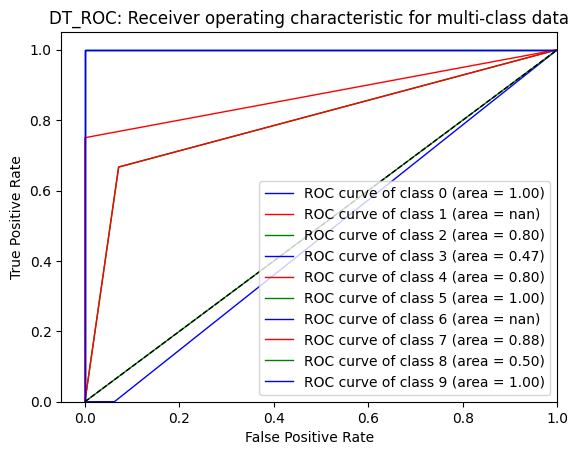

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Average ROC for KNN_ROC: 0.6549908424908425


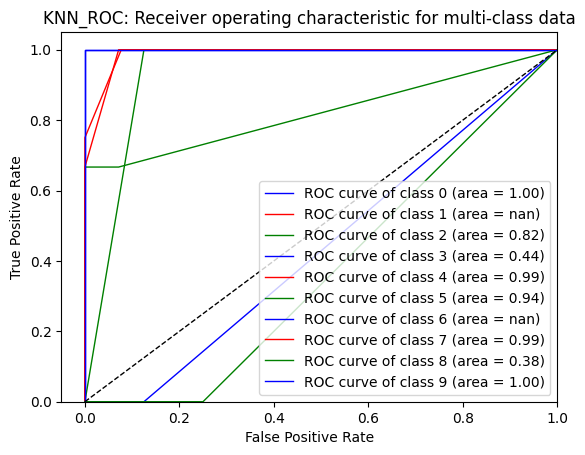

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Average ROC for RF_ROC: 0.7138621794871794


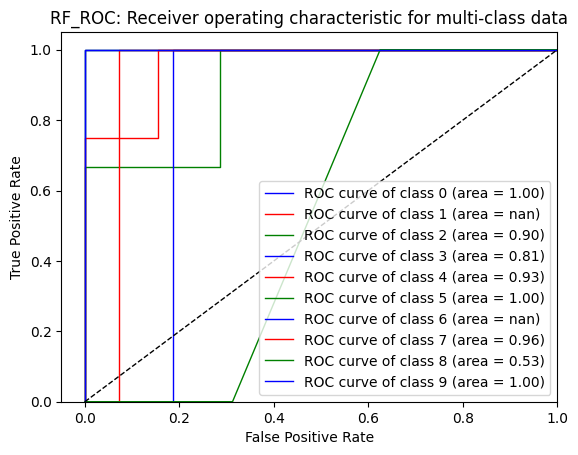

In [ ]:
# GENERATING ROC CURVES FOR 3 MODELS
import pandas as pd
import numpy as np
from numpy import nan
import matplotlib.pyplot as plt
from itertools import cycle
import sys
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

y = label_binarize(label, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

classifiers = {
    'DT_ROC': DecisionTreeClassifier(),
    'KNN_ROC': KNeighborsClassifier(),
    'RF_ROC': RandomForestClassifier()
}

for x in classifiers:
  n_classes = y.shape[1]
  classifier = OneVsRestClassifier(classifiers[x])
  x_train_roc, x_test_roc, y_train_roc, y_test_roc = train_test_split(df, y, test_size=0.2, random_state=0)
  y_score = classifier.fit(x_train_roc, y_train_roc).predict_proba(x_test_roc)

  # print(y_score)

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  sum = 0
  i = 0
  for i in range(n_classes):
      # print(y_test_roc[:, i])
      # print(y_score[:, i])
      fpr[i], tpr[i], _ = roc_curve(y_test_roc[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
      if(not np.isnan(roc_auc[i])):
        sum += roc_auc[i]
        i += 1

  print("Average ROC for {}: {}".format(x, sum/i))

  colors = cycle(['blue', 'red', 'green'])
  lw=1
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([-0.05, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title("{}: Receiver operating characteristic for multi-class data".format(x))
  plt.legend(loc="lower right")
  plt.savefig('/content/drive/MyDrive/ImageProcessingAlgoV2/ColabGen/i' + x + '.png')
  plt.show()